In a graph generated in Changing K means metric notebook, we saw that the dot similarity was consistently underperforming compared to the cosine and euclidean similarity used in Kmeans algorithm. Why could this be? One hypothesis is that the outliers of a cluster as identified by dot similarity are not in fact outliers of the cluster as determined by another metric like euclidean distance.

Now to test this, we identify the nodes which are misidentified by the clustering algorithm when using K-Means with Dot similarity that are not misidentified by the clustering algorithm when using K-Means with Euclidean distance. 

Keep this set of nodes out, and run kmeans until the clusters are stabilized and in the last run, reintroduce these nodes and assign them clusters whose centroids they are closest to. Now recalculate the element centric similarity. Does this improve the performance? Let's find out

In [1]:
'''
Writing this script such that if I run it with input parameters, 
it should give me element centric similarity for the methods, we query
each method we query can run withinn this or out. Will decide.
Use chanage_mu_test.py as reference.
'''
import numpy as np
from scipy import sparse
import pandas as pd
#import os
#import networkx as nx
#import gensim
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.linear_model import LogisticRegression 
import faiss
import fast_hdbscan
#import lfr
#import embcom
#import csv
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
#from scripts.clustering_methods import clustering_method_values
from scripts.nets_and_embeddings import load_net_and_embedding

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
import numpy as np
import belief_propagation
import infomap
from graph_tool.all import Graph,minimize_blockmodel_dl

# Need net, node_table and emb files
# net is G, emb files are wv, node_table probably
# has some info about ground truth community labels or smth like that.

# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dotsim",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances

# Only place where GPU is used, need to handle its closing. 
def find_knn(target, emb, num_neighbors, metric="dotsim", device=None): 
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    elif metric == "euclidean":
        index = faiss.IndexFlatL2(emb.shape[1])
    elif metric == "manhattan":
        index = faiss.IndexFlatL1(emb.shape[1])
    elif metric == "cosine":
        index = faiss.IndexFlatIP(emb.shape[1])
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    elif metric=="mahalanobis":
        # THis mathematical trick works, but it needs some reworking in target.astype to
        # give right results.
        # map the vectors back to a space where they follow a unit Gaussian
        xc = emb - emb.mean(0)
        cov = np.dot(xc.T, xc) / xc.shape[0]
        L = np.linalg.cholesky(cov)
        mahalanobis_transform = np.linalg.inv(L)
        emb = np.dot(emb, mahalanobis_transform.T)
        index = faiss.IndexFlatL2(emb.shape[1])
    else:
        raise ValueError("Invalid metric specified.")
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            elif metric == "euclidean":
                index = faiss.IndexFlatL2(emb.shape[1])
            elif metric == "manhattan":
                index = faiss.IndexFlatL1(emb.shape[1])
            elif metric == "cosine":
                index = faiss.IndexFlatIP(emb.shape[1])
                emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            else:
                raise ValueError("Invalid metric specified.")
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
        
    index.reset()
    return indices, distances

import numba

def louvain(Z, w1, b0, num_neighbors=100, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()
    
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
               Z=Vt,
               num_neighbors=num_neighbors,
               rho=b0/w1,
               node_size=node_size,
               epochs=iteration,
               device=device,
                )
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None,epochs=50): # This involves distance metrics (cosine similarity, atm)
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,epochs=100):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id]))

            for cprime in clist:
                if c == cprime: 
                    continue
                dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                        - rho * node_size[node_id] * Nc[cprime]) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids


In [2]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import check_random_state
from numba import njit

class CustomKMeans:
    def __init__(self, n_clusters, metric='euclidean', max_iter=300, tol=1e-4, random_state=None, n_init=10, init='k-means++', batch_size=None):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.n_init = n_init
        self.init = init
        self.batch_size = batch_size  # Mini-batch size, if any

    def calculate_distances(self, X, centroids):
        """Optimized distance calculation for the specified metric."""
        if self.metric == 'euclidean':
            return cdist(X, centroids, metric='euclidean')
        elif self.metric == 'manhattan':
            return cdist(X, centroids, metric='cityblock')
        elif self.metric == 'cosine':
            return 1 - cosine_similarity(X, centroids)
        elif self.metric == 'dot':
            return -np.dot(X, centroids.T)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

    def _initialize_centroids(self, X, rng):
        """Efficient k-means++ initialization."""
        centroids = [X[rng.randint(X.shape[0])]]
        closest_dist_sq = self.calculate_distances(X, np.array(centroids))[:, 0] ** 2

        for _ in range(1, self.n_clusters):
            probs = closest_dist_sq / closest_dist_sq.sum()
            cumulative_probs = np.cumsum(probs)
            r = rng.rand()
            new_centroid = X[np.searchsorted(cumulative_probs, r)]
            centroids.append(new_centroid)
            new_dist_sq = self.calculate_distances(X, np.array([new_centroid]))[:, 0] ** 2
            closest_dist_sq = np.minimum(closest_dist_sq, new_dist_sq)
        
        return np.array(centroids)

    @staticmethod
    @njit
    def _update_centroids(X, labels, n_clusters):
        """Compute new centroids using JIT compilation for efficiency."""
        new_centroids = np.zeros((n_clusters, X.shape[1]), dtype=X.dtype)
        counts = np.zeros(n_clusters, dtype=np.int64)
        
        for i in range(X.shape[0]):
            new_centroids[labels[i]] += X[i]
            counts[labels[i]] += 1
        
        for j in range(n_clusters):
            if counts[j] > 0:
                new_centroids[j] /= counts[j]
        
        return new_centroids

    def _run_kmeans(self, X, rng):
        """Run a single instance of K-means clustering with optional mini-batch."""
        centroids = self._initialize_centroids(X, rng)
        n_samples = X.shape[0]

        for i in range(self.max_iter):
            if self.batch_size:
                batch_indices = rng.choice(n_samples, self.batch_size, replace=False)
                X_batch = X[batch_indices]
                distances = self.calculate_distances(X_batch, centroids)
                labels = np.argmin(distances, axis=1)
            else:
                distances = self.calculate_distances(X, centroids)
                labels = np.argmin(distances, axis=1)
            
            new_centroids = self._update_centroids(X, labels, self.n_clusters)
            
            # Convergence check based on relative tolerance
            centroid_shifts = np.linalg.norm(new_centroids - centroids, axis=1)
            if np.all(centroid_shifts < self.tol * np.linalg.norm(centroids, axis=1)):
                break
            
            centroids = new_centroids
        
        # Inertia calculation for this run
        inertia = np.sum(np.min(distances, axis=1) ** 2)
        return centroids, labels, inertia

    def fit(self, X):
        """Run KMeans with multiple initializations to get the best clustering."""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        rng = check_random_state(self.random_state)

        for _ in range(self.n_init):
            centroids, labels, inertia = self._run_kmeans(X, rng)
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        
        # Set final results
        self.centroids_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to."""
        distances = self.calculate_distances(X, self.centroids_)
        return np.argmin(distances, axis=1)

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse import find
from sklearn.linear_model import LogisticRegression
import fast_hdbscan  # Assuming fast_hdbscan is a placeholder for the actual import
#from custom_kmeans import CustomKMeans  # Importing modified K-means with metrics
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

def clustering_method_values(net, community_table, emb, score_keys, device_name):
    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()

    def proposed_method_labels(emb, device_name):
        rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=500, device=device_name)
        cneg = np.random.choice(emb.shape[0], len(cpos))
        vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

        model = LogisticRegression()
        model.fit(
            np.concatenate([vpos, vneg]).reshape((-1, 1)),
            np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
        )
        w1, b0 = model.coef_[0, 0], -model.intercept_[0]
        return louvain(emb, w1, b0, device=device_name)

    def method_score(key):
        if key == "kmeans":
            kmeans = KMeans(n_clusters=len(set(community_table["community_id"])), random_state=0).fit(X)
            return calc_esim(community_table["community_id"], kmeans.labels_)

        elif key.startswith("kmeans_"):  # Parse metric and apply CustomKMeans with modified metrics
            metric = key.split("_", 1)[1]
            custom_kmeans = CustomKMeans(n_clusters=len(set(community_table["community_id"])), metric=metric, random_state=0).fit(emb)
            return calc_esim(community_table["community_id"], custom_kmeans.labels_)

        elif key == "dbscan":
            clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=len(set(community_table["community_id"])))
            dbscan_labels = clusterer.fit_predict(X)
            return calc_esim(community_table["community_id"], dbscan_labels)

        elif key == "optics":
            optics = OPTICS().fit(X)
            return calc_esim(community_table["community_id"], optics.labels_)

        elif key == "proposed":
            return calc_esim(community_table["community_id"], proposed_method_labels(emb, device_name))

        elif key == "xmeans":
            initial_centers = kmeans_plusplus_initializer(X, amount_centers=len(set(community_table['community_id']))).initialize()
            xmeans_mndl = xmeans(X, initial_centers, 20, splitting_type=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH)
            xmeans_mndl.process()
            mndl_clusters = xmeans_mndl.get_clusters()
            xmeans_labels = [i[1] for i in sorted([(j, i) for i in range(len(mndl_clusters)) for j in mndl_clusters[i]])]
            return calc_esim(community_table["community_id"], xmeans_labels)

        elif key == "belief_prop":
            belief_prop_labels = belief_propagation.detect(net, q=len(set(community_table['community_id'])), init_memberships=community_table["community_id"])
            return calc_esim(community_table["community_id"], belief_prop_labels)

        elif key == "infomap":
            r, c, v = find(net + net.T)
            im = infomap.Infomap(silent=True)
            for i in range(len(r)):
                im.add_link(r[i], c[i], 1)
            im.run()

            cids = np.zeros(net.shape[0])
            for node in im.tree:
                if node.is_leaf:
                    cids[node.node_id] = node.module_id

            infomap_labels = np.unique(cids, return_inverse=True)[1]
            return calc_esim(community_table["community_id"], infomap_labels)

        elif key == "flatsbm":
            r, c, v = find(net)
            g = Graph(directed=False)
            g.add_edge_list(np.vstack([r, c]).T)
            K = len(set(community_table['community_id']))
            state = minimize_blockmodel_dl(
                g,
                state_args={"B_min": K, "B_max": K},
                multilevel_mcmc_args={"B_max": K, "B_min": K},
            )
            b = state.get_blocks()
            flatsbm_labels = np.unique(np.array(b.a), return_inverse=True)[1]
            return calc_esim(community_table["community_id"], flatsbm_labels)

    # Calculate and store scores for each clustering method in score_keys
    score_dictionary = {}
    for key in score_keys:
        score_dictionary[key] = method_score(key)

    return score_dictionary

In [4]:
N=10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05),decimals=2)

params = {
    "N": N,
    "k": 50,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.2,
    }


emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

run_no = 1
path_name= f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/Run_{run_no}/"

#"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_0.1_k_50_mincomm_50.npz"

net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

score_keys=['kmeans_euclidean','kmeans_cosine','kmeans_dot','kmeans_manhattan']
clustering_method_values(net, community_table, emb, score_keys, device_name = "cuda:0")

{'kmeans_euclidean': 0.962950732048327,
 'kmeans_cosine': 0.9127919498311355,
 'kmeans_dot': 0.7581220730617779,
 'kmeans_manhattan': 0.9449454601476401}

In [19]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

# Define the element-centric similarity function
def calc_esim(y, ypred):
    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N, K))
    UB = csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)
    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N

    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

# Function to identify misidentified nodes
def get_misidentified_nodes(y_true, y_dot, y_euclidean):
    ylab, y_true = np.unique(y_true, return_inverse=True)
    ydotlab, y_dot = np.unique(y_dot, return_inverse=True)
    yeuclab, y_euclidean = np.unique(y_euclidean, return_inverse=True)

    Ka, Kb = len(ylab), len(ydotlab)
    Kc = len(yeuclab)
    K = max(Ka, Kb, Kc)
    N = len(y_true)

    UA = csr_matrix((np.ones_like(y_true), (np.arange(N), y_true)), shape=(N, K))
    U_dot = csr_matrix((np.ones_like(y_dot), (np.arange(N), y_dot)), shape=(N, K))
    U_euclidean = csr_matrix((np.ones_like(y_euclidean), (np.arange(N), y_euclidean)), shape=(N, K))

    correct_dot = np.array((UA.multiply(U_dot)).sum(axis=1)).reshape(-1) > 0
    correct_euclidean = np.array((UA.multiply(U_euclidean)).sum(axis=1)).reshape(-1) > 0
    misidentified_nodes = np.where(~correct_dot & correct_euclidean)[0]
    #misidentified_nodes = np.where(~correct_dot )[0]

    return misidentified_nodes

# Run modified K-Means without label alignment
def run_modified_kmeans(emb, community_table, device_name):
    n_clusters = len(set(community_table["community_id"]))
    kmeans_euclidean = CustomKMeans(n_clusters=n_clusters, metric="euclidean", random_state=0)
    kmeans_euclidean.fit(emb)
    labels_euclidean = kmeans_euclidean.labels_
    inital_score = calc_esim(community_table["community_id"], labels_euclidean)

    print("Euclidean ESIM:", inital_score)

    kmeans_dot = CustomKMeans(n_clusters=n_clusters, metric="dot", random_state=0)
    kmeans_dot.fit(emb)
    labels_dot = kmeans_dot.labels_
    inital_score = calc_esim(community_table["community_id"], labels_dot)
    print("Element-Centric Similarity without Dot Similarity Reassignment:", inital_score)

    # Identify misidentified nodes without label alignment
    misidentified_nodes = get_misidentified_nodes(
        community_table["community_id"], labels_dot, labels_euclidean
    )
    print(len(misidentified_nodes)*100/len(community_table))

    # Mask to exclude misidentified nodes
    mask = np.ones(emb.shape[0], dtype=bool)
    mask[misidentified_nodes] = False
    kmeans_dot_filtered = CustomKMeans(n_clusters=n_clusters, metric="dot", random_state=0)
    kmeans_dot_filtered.fit(emb[mask])
    filtered_labels_dot = kmeans_dot_filtered.labels_
    sanity_score = calc_esim(community_table["community_id"][mask], filtered_labels_dot)
    print("Element-Centric Similarity before Dot Similarity Reassignment:", sanity_score)

    # Assign filtered labels back to the original node indices
    final_labels = np.full(emb.shape[0], -1)
    final_labels[mask] = filtered_labels_dot

    # Reintroduce misidentified nodes using Dot similarity
    centroids = kmeans_dot_filtered.centroids_
    for node in misidentified_nodes:
        distances = -np.dot(emb[node], centroids.T)
        closest_centroid = np.argmin(distances)
        final_labels[node] = closest_centroid

    # Calculate element-centric similarity
    final_score = calc_esim(community_table["community_id"], final_labels)
    print("Modified Element-Centric Similarity with Dot Similarity Reassignment:", final_score)
    return labels_dot,final_labels, labels_euclidean, filtered_labels_dot, mask

# Assuming you have your embeddings (emb) and community labels (community_table) loaded
labels_dot,final_labels, labels_euclidean, filtered_labels_dot, mask = run_modified_kmeans(emb, community_table, device_name="cuda:0")


Euclidean ESIM: 0.962950732048327
Element-Centric Similarity without Dot Similarity Reassignment: 0.7581220730617779
15.5
Element-Centric Similarity before Dot Similarity Reassignment: 0.6647395515032734
Modified Element-Centric Similarity with Dot Similarity Reassignment: 0.4973190432137084


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

def reduce_embeddings_umap(emb, n_neighbors=15, min_dist=0.1, random_state=0):
    """
    Reduces embeddings to 2D using UMAP.
    
    Parameters:
    - emb: Array-like, shape (n_samples, n_features) - Original embeddings of nodes.
    - n_neighbors: UMAP n_neighbors parameter, controls local structure.
    - min_dist: UMAP min_dist parameter, controls clustering.
    - random_state: Seed for reproducibility.
    
    Returns:
    - reduced_emb: Array-like, shape (n_samples, 2) - 2D reduced embeddings.
    """
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    reduced_emb = reducer.fit_transform(emb)
    return reduced_emb

def plot_clusters_shared_axes(reduced_emb, label_sets, titles):
    """
    Plots multiple cluster sets on shared axes with the same 2D embedding coordinates.
    
    Parameters:
    - reduced_emb: Array-like, shape (n_samples, 2) - 2D embeddings of nodes.
    - label_sets: List of label arrays, each representing cluster labels for nodes.
    - titles: List of titles for each subplot.
    """
    num_plots = len(label_sets)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharex=True, sharey=True)
    
    # Get axis limits from the full embedding space for consistency
    x_min, x_max = np.min(reduced_emb[:, 0]), np.max(reduced_emb[:, 0])
    y_min, y_max = np.min(reduced_emb[:, 1]), np.max(reduced_emb[:, 1])

    for i, (labels, title) in enumerate(zip(label_sets, titles)):
        ax = axes[i] if num_plots > 1 else axes  # Handle single subplot case
        scatter = ax.scatter(reduced_emb[:, 0], reduced_emb[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
        ax.set_title(title)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        fig.colorbar(scatter, ax=ax, label="Cluster Labels")

    plt.suptitle("Cluster Plots with Shared Axes", fontsize=16)
    plt.show()

# Example usage
# Reduce dimensionality of the full embedding array using UMAP
reduced_emb = reduce_embeddings_umap(emb)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

def reduce_embeddings_umap(emb, n_neighbors=15, min_dist=0.1, random_state=0):
    """
    Reduces embeddings to 2D using UMAP.
    
    Parameters:
    - emb: Array-like, shape (n_samples, n_features) - Original embeddings of nodes.
    - n_neighbors: UMAP n_neighbors parameter, controls local structure.
    - min_dist: UMAP min_dist parameter, controls clustering.
    - random_state: Seed for reproducibility.
    
    Returns:
    - reduced_emb: Array-like, shape (n_samples, 2) - 2D reduced embeddings.
    """
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    reduced_emb = reducer.fit_transform(emb)
    return reduced_emb

# Example usage
# Reduce dimensionality of the full embedding array using UMAP
reduced_emb = reduce_embeddings_umap(emb)

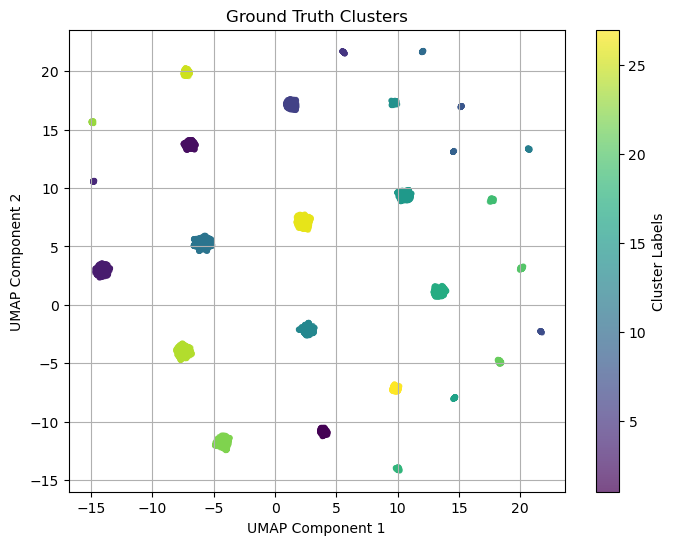

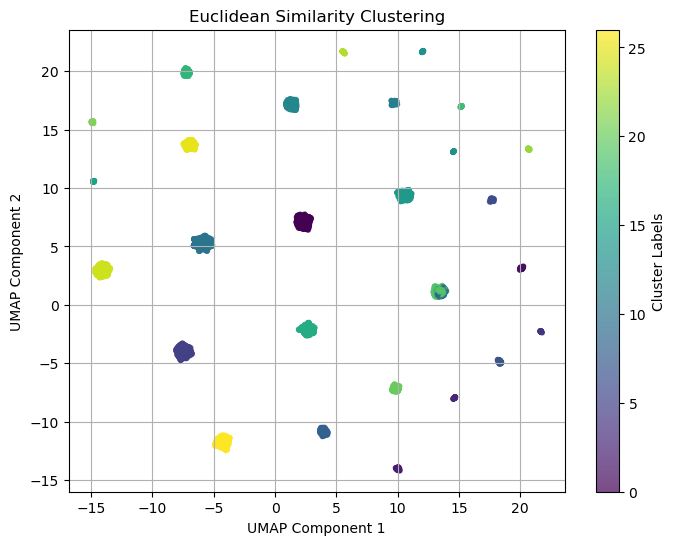

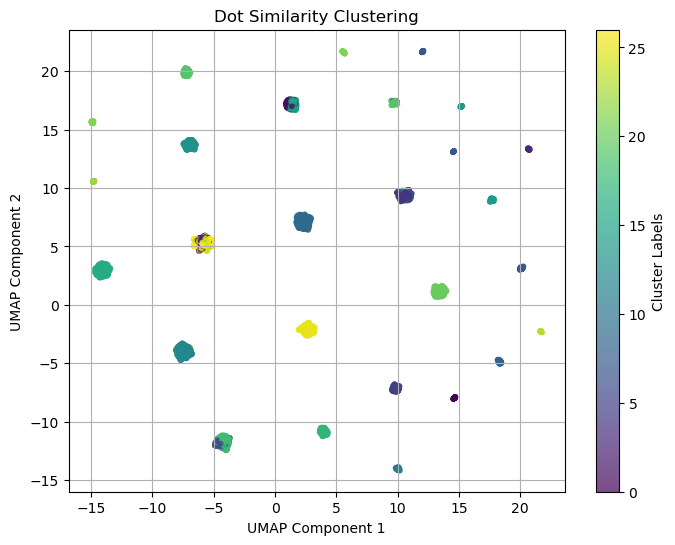

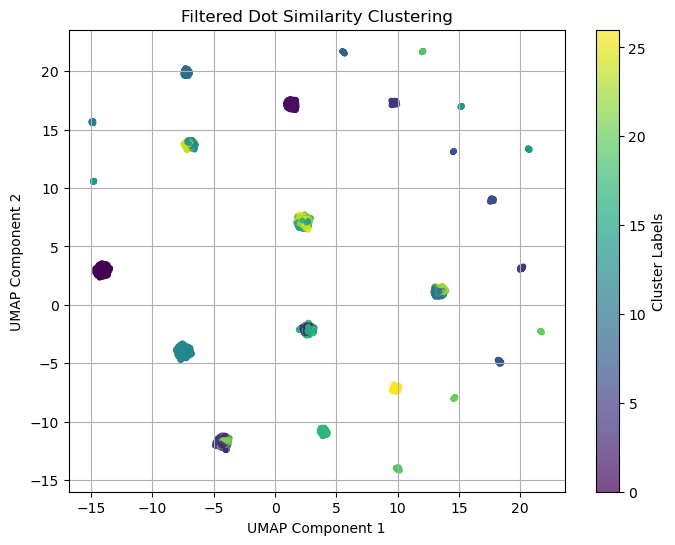

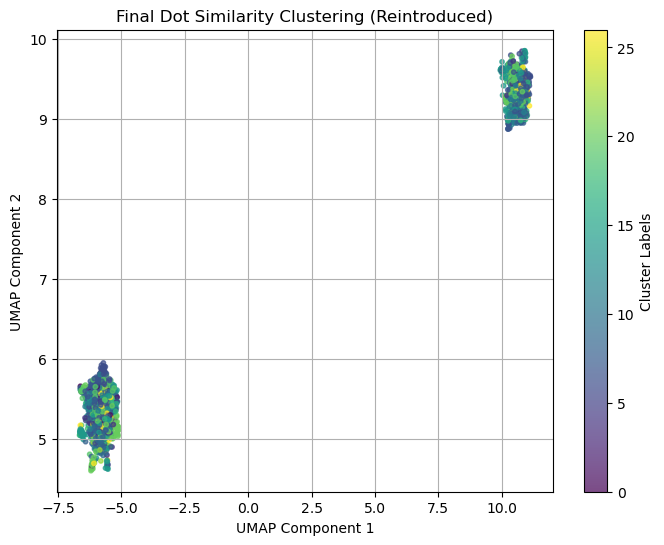

In [35]:

def plot_cluster(reduced_emb, labels, title):
    """
    Plots a single cluster set in 2D with UMAP-reduced coordinates.
    
    Parameters:
    - reduced_emb: Array-like, shape (n_samples, 2) - 2D embeddings of nodes.
    - labels: Array-like, shape (n_samples,) - Cluster labels for nodes.
    - title: Title for the plot.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Cluster Labels")
    plt.title(title)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.grid(True)
    plt.show()


# Plot each cluster set individually
plot_cluster(reduced_emb, community_table["community_id"], "Ground Truth Clusters")
plot_cluster(reduced_emb, labels_euclidean, "Euclidean Similarity Clustering")
plot_cluster(reduced_emb, labels_dot, "Dot Similarity Clustering")
plot_cluster(reduced_emb[mask], filtered_labels_dot, "Filtered Dot Similarity Clustering")
plot_cluster(reduced_emb[~mask], final_labels[~mask], "Final Dot Similarity Clustering (Reintroduced)")


As we can see here, the performance actually deteriorates if we remove the misclassified nodes that dot similarity produced (but euclidean sim didn't). This is because the misclassified nodes were all actually belonging to two clusters, so removing these two clusters, now mean't that the K-2 nodes that remained had to be clustered into K clusters, which caused the error to increase actually. So this still leaves us with the question of, why does dot similarity underperfrorm?